In [1]:
from multivp_dataset import MULTI_VP_Dataset
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from tqdm.notebook import tqdm
import datetime

from models.gru_pyramid import Generator, Discriminator
from tools.viz import plot_anomalies, plot_single_var, plot_to_tensorboard, plot_anomaly_scores, plot_train_hist
from tools.anomaly import madgan_reconstruction, madgan_reconstruction_discr_loss, feature_anomaly_score

time_id = datetime.datetime.now().strftime("%m%d-%H%M")

class Options:
    def __init__(self):
        # Dataset
        self.data_path = Path('../data/compiled/inputs.csv')
        self.batch_size = 18
        self.nworkers = 4
        self.shuffle = True
        self.drop_last = False
        self.method = "window_mag"
        # self.nseqs = 4
        self.scaler = MinMaxScaler((-1,1))
        self.wsize = 5
        
        # Train params
        self.lr = 0.0001
        self.epochs = 25
        self.G_niters = 5
        self.D_niters = 10
        
        self.model_out = Path('./runs/gru_pyr/' + time_id + '_w5')
        self.train_plots = True

        # create ouput dirs
        if not self.model_out.exists(): self.model_out.mkdir(parents=True)
        
        (self.model_out / "img").mkdir(exist_ok=True)
        
opts = Options()


# Setup Training Dataset

In [2]:
dataset = MULTI_VP_Dataset(
    path=opts.data_path,
    method=opts.method,
    remove_extreme=True,
    is_train=True,
    scaler=opts.scaler,
    # nseqs=opts.nseqs
    window_size=opts.wsize,
    # use_pca=True,
    # pca_scaler=MinMaxScaler((-1,1)),
    # n_components=128   
)
dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=True, num_workers=opts.nworkers, drop_last=False)

Removed 705 extreme values
Window size: 5
Window shape:  torch.Size([5, 640])
First window:
 tensor([[-0.4835, -0.4830, -0.4826,  ...,  0.9998,  0.9998,  0.9999],
        [-0.4728, -0.4724, -0.4719,  ...,  0.9999,  0.9999,  0.9999],
        [-0.4461, -0.4456, -0.4452,  ...,  0.9999,  0.9999,  0.9999],
        [-0.4908, -0.4903, -0.4899,  ...,  0.9999,  0.9999,  0.9999],
        [-0.4562, -0.4557, -0.4553,  ...,  0.9999,  0.9999,  0.9999]])
Inputs shape: (11066, 640)
Inputs head:
 [[-0.4834911  -0.48303799 -0.48258295 ...  0.99983155  0.99984836
   0.99986353]
 [-0.47284225 -0.4723928  -0.47194147 ...  0.99986533  0.99987877
   0.99989089]
 [-0.44609133 -0.44563623 -0.44517925 ...  0.99987057  0.99988349
   0.99989514]
 [-0.49076893 -0.49033704 -0.4899033  ...  0.99988016  0.99989212
   0.99990291]
 [-0.45617043 -0.45574015 -0.45530805 ...  0.99986605  0.99987941
   0.99989148]]


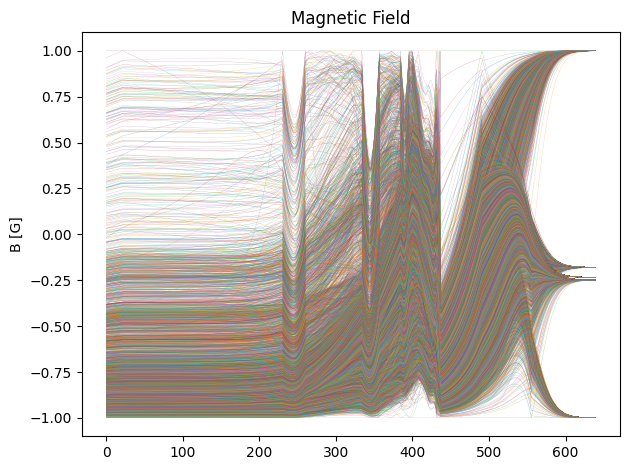

In [3]:
dataset.plot(title="Magnetic Field")

# Models

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

netG = Generator(
    input_size=dataset.inputs.shape[1],
    hidden_size=160,
    output_size=dataset.inputs.shape[1],
    device=device,
    num_layers=1,
    # dropout=0.1,
    bidirectional=False
).to(device)

netD = Discriminator(
    input_size=dataset.inputs.shape[1],
    hidden_size=160,
    device=device,
    num_layers=1,
    dropout=0.1,
    bidirectional=False
).to(device)

Using device:  cuda:0


/home/ivsaav/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [5]:
netG.train()

Generator(
  (lstm0): GRU(640, 160, batch_first=True)
  (lstm1): GRU(160, 320, batch_first=True)
  (lstm2): GRU(320, 640, batch_first=True)
  (linear): Linear(in_features=640, out_features=640, bias=True)
)

In [6]:
netD.train()

Discriminator(
  (lstm): GRU(640, 160, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=160, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [7]:
logger = SummaryWriter(f"logs/gru_pyr/{time_id}_D{netD.hidden_size}-L{netD.num_layers}_G{netG.hidden_size}-L{netG.num_layers}")
logger.add_graph(netG, torch.randn(opts.batch_size, opts.wsize, dataset.inputs.shape[1]).to(device))
logger.add_graph(netD, torch.randn(opts.batch_size,opts.wsize, dataset.inputs.shape[1]).to(device))
logger.add_text("Generator", netG.__str__())
logger.add_text("Discriminator", netD.__str__())

with open(opts.model_out / "model.txt", "w") as f:
    f.write("Generator" + str(netG) + "\n")
    f.write("Discriminator" + str(netD) + "\n")

2023-03-14 14:41:12.318349: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Training

In [8]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

nseqs = opts.wsize

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=opts.lr)
optimizerG = optim.Adam(netG.parameters(), lr=opts.lr)

In [9]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0
best_loss = np.inf
best_loss_dist = np.inf

print("Starting Training Loop...")
# For each epoch
for epoch in range(opts.epochs):
    D_epoch_loss = 0
    G_epoch_loss = 0
    
    # For each batch in the dataloader
    for i, (x, _filename) in tqdm(enumerate(dataloader), desc=f"Epoch [{epoch}/{opts.epochs}]", total=len(dataloader), leave=False):
        
        # Format batch
        real = x.to(device)
        b_size, seq_len = real.size(0), real.size(1)
        real_labels = torch.full((b_size, nseqs, 1), real_label, dtype=torch.float, device=device)
        
        # Train discriminator network to maximize log(D(x)) + log(1 - D(G(z)))
        for _ in range(opts.D_niters):
            netD.zero_grad()
            
            # Train with real batch
            output = netD(real)
            errD_real = criterion(output, real_labels)
            errD_real.backward()
            
            # Train with fake batch
            fake = netG(torch.randn_like(real, device=device))
            fake_labels = torch.full((b_size, nseqs, 1), fake_label, dtype=torch.float, device=device)
            
            output = netD(fake.detach())
            errD_fake = criterion(output, fake_labels)
            errD_fake.backward()
            
            errD = errD_real + errD_fake
            optimizerD.step()
        D_losses.append(errD.item())
        
        # Train generator network to maximize log(D(G(z)))
        for _ in range(opts.G_niters):
            netG.zero_grad()
            
            fake = netG(torch.randn_like(real, device=device))
            output = netD(fake)
            errG = criterion(output, real_labels)
            errG.backward()
            optimizerG.step()
        G_losses.append(errG.item())
        # send losses to tensorboard
        logger.add_scalars('Loss/train', {'G': errG.item(), 'D': errD.item()}, iters)
        iters += 1
        
    # Calculate epoch losses
    output = netD(real)
    errD_real = criterion(output, real_labels)
    D_x = output.mean().item()
    
    fake = netG(torch.randn_like(real, device=device))
    output = netD(fake.detach())
    errD_fake = criterion(output, fake_labels)
    D_G_z1 = output.mean().item()
    
    errD = errD_real + errD_fake
    errG = criterion(output, real_labels)

    # Output training stats
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
            % (epoch, opts.epochs,
                errD.item(), errG.item(), D_x, D_G_z1))

    # save best model if total loss is better than last 
    # and distance between losses is better than last (model convergence)
    if abs(errD-errG).item() < best_loss_dist and epoch > 2 and D_x > 0.7: 
        best_loss_dist = torch.abs(errD-errG).item()
        torch.save(netG.state_dict(), opts.model_out / 'Gbest.pth')
        torch.save(netD.state_dict(), opts.model_out / 'Dbest.pth')
        
        if opts.train_plots:
            fake = dataset.unscale(fake.detach().cpu().numpy())
            # fake = dataset.flatten(fake.detach().cpu().numpy())
            fig = plot_single_var(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f} - Loss diff: {best_loss_dist:.4f}",
                            dpi=200, scale="linear")
            fig.savefig(opts.model_out / f"img/{epoch}_best", dpi=200)
            plot_to_tensorboard(logger, fig, epoch, "train/best")
            plt.close(fig)
    elif epoch % 5 == 0:
        torch.save(netG.state_dict(), opts.model_out / f'G{epoch}.pth')
        torch.save(netD.state_dict(), opts.model_out / f'D{epoch}.pth')
        
        if opts.train_plots:
            # fake = dataset.flatten(fake.detach().cpu().numpy())
            fake = dataset.unscale(fake.detach().cpu().numpy())
            fig = plot_single_var(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f} - Loss diff: {best_loss_dist:.4f}",
                            dpi=200, scale="linear")
            fig.savefig(opts.model_out / f'img/inter_{epoch}.png', dpi=200)
            plot_to_tensorboard(logger, fig, epoch, "train/inter")
            plt.close(fig)
            
        train_f = plot_train_hist(D_losses, G_losses, opts.model_out)
        plt.close(train_f)
    

Starting Training Loop...


Epoch [0/25]:   0%|          | 0/615 [00:00<?, ?it/s]

RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

In [ ]:
logger.flush()

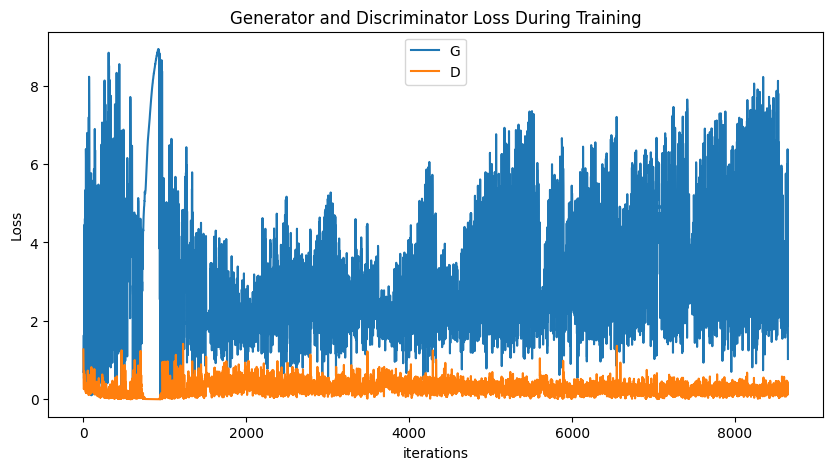

In [ ]:
fig = plot_train_hist(D_losses, G_losses, opts.model_out)

# Anomaly Detection

In [ ]:

netD.train(True)
netG.train(True)

class AnomalyParams:
    batch_size = 128
    models_dir = opts.model_out
    # models_dir = Path("./runs/gru_pyr/0313-2017_w5")
    # reconstruction based
    niter = 100 # number of iterations for reconstruction
    lambda_thresh = 0.1
    lr = 1e-2
    
opts_eval = AnomalyParams()

# load best models
netG.load_state_dict(torch.load(opts_eval.models_dir / 'Gbest.pth'))
netD.load_state_dict(torch.load(opts_eval.models_dir / 'Dbest.pth'))

<All keys matched successfully>

In [ ]:
eval_dataset = MULTI_VP_Dataset._from(dataset)
# eval_dataset = MULTI_VP_Dataset(opts.data_path, method=opts.method, scaler=opts.scaler, window_size=10, pca=True, n_components=opts.n_components)
eval_dataloader = DataLoader(eval_dataset, batch_size=opts_eval.batch_size, shuffle=False, num_workers=opts.nworkers)

Window size: 5
Window shape:  torch.Size([5, 640])
First window:
 tensor([[-0.4835, -0.4830, -0.4826,  ...,  0.9998,  0.9998,  0.9999],
        [-0.4728, -0.4724, -0.4719,  ...,  0.9999,  0.9999,  0.9999],
        [-0.4461, -0.4456, -0.4452,  ...,  0.9999,  0.9999,  0.9999],
        [-0.4908, -0.4903, -0.4899,  ...,  0.9999,  0.9999,  0.9999],
        [-0.4562, -0.4557, -0.4553,  ...,  0.9999,  0.9999,  0.9999]])
Inputs shape: (11771, 640)
Inputs head:
 [[-0.4834911  -0.48303799 -0.48258295 ...  0.99983155  0.99984836
   0.99986353]
 [-0.47284225 -0.4723928  -0.47194147 ...  0.99986533  0.99987877
   0.99989089]
 [-0.44609133 -0.44563623 -0.44517925 ...  0.99987057  0.99988349
   0.99989514]
 [-0.49076893 -0.49033704 -0.4899033  ...  0.99988016  0.99989212
   0.99990291]
 [-0.45617043 -0.45574015 -0.45530805 ...  0.99986605  0.99987941
   0.99989148]]


## Discriminator Classification

In [ ]:
scores = []
# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    outputs = netD(x.to(device))
    # print(outputs.shape)
    # calculate mean classification score for each sample
    for sample, filename in zip(outputs, filenames):
        # print(sample, filename)
        # print(filename)
        class_avg = sample[0]
        scores.append((filename, 1-class_avg.item()))

Anomaly Threshold:  0.5011745989322662
Found 1176 anomalies


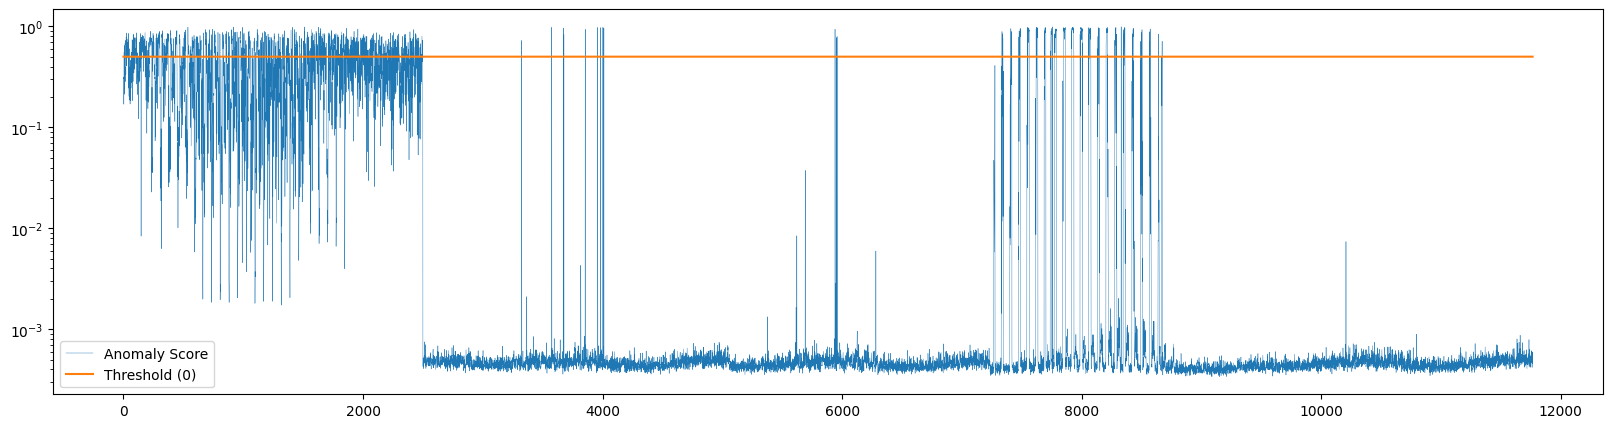

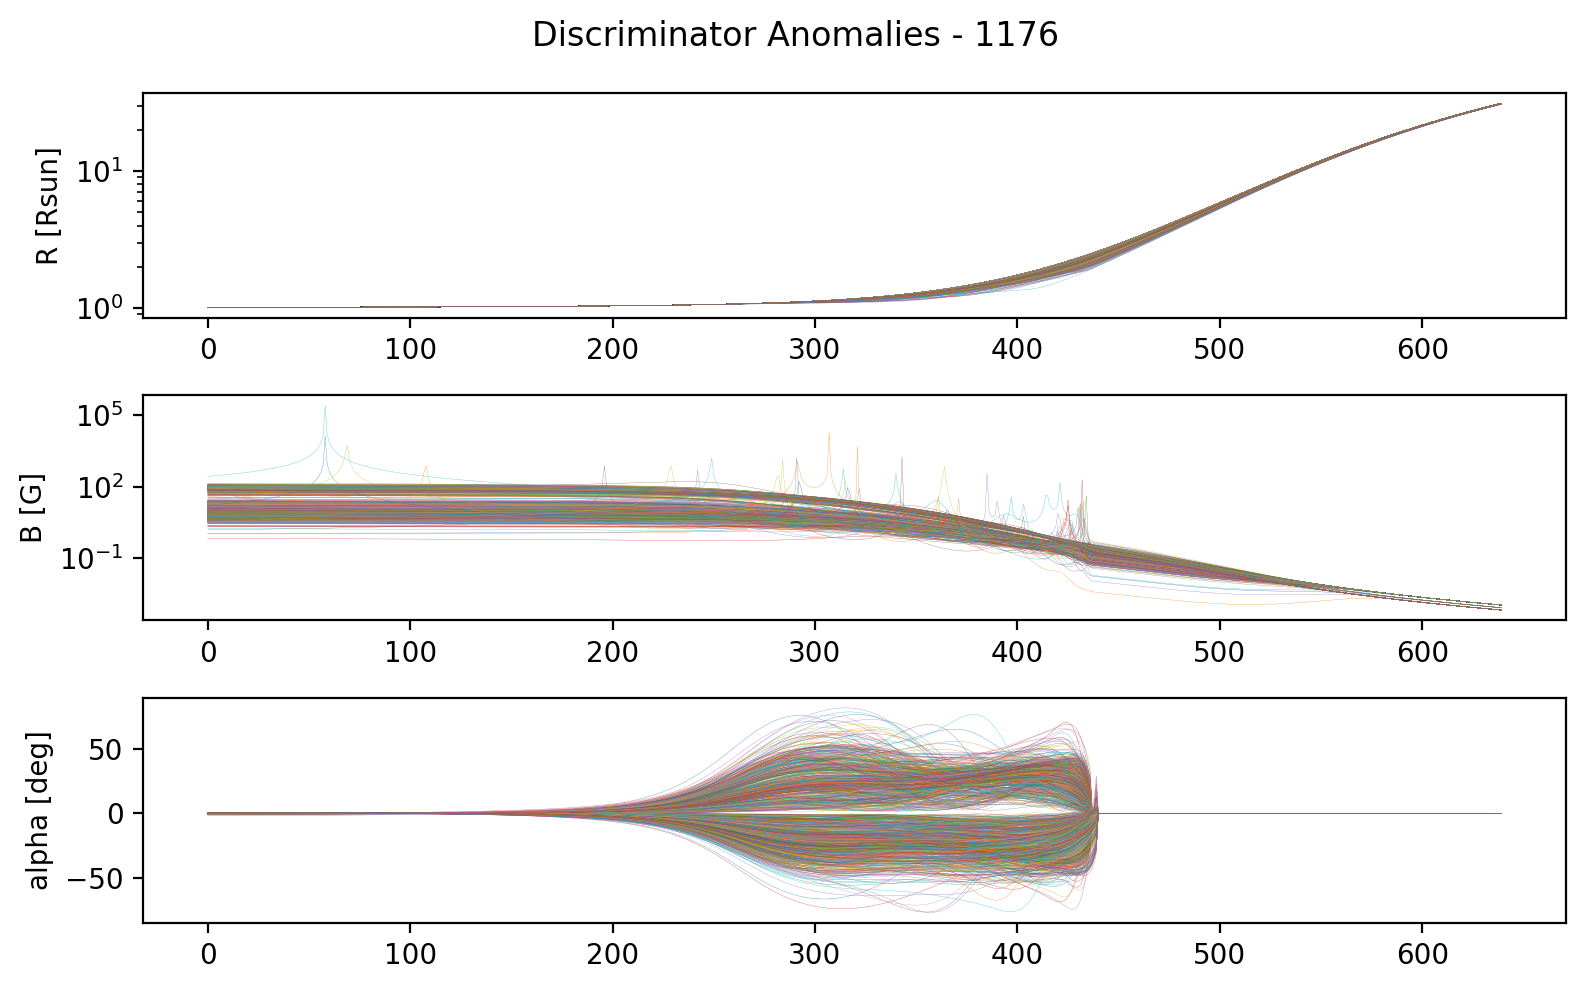

In [ ]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(scores, 0.1, opts.data_path, opts_eval.models_dir /  f"img/discr_scores",
                        scale="log", method="Discriminator", logger=logger, logger_var="test/discr")

## Reconstruction Based

In [ ]:
def reconstruction_anomaly_scores(dataloader, netG : nn.Module, netD : nn.Module, device : str,
                                  max_iters=100, reconstr_fn=madgan_reconstruction):
    mse_scores = []
    for i, (x, filenames) in enumerate(dataloader, 0):
        _z, loss = reconstr_fn(x, netG, netD, device, max_iters)
        mse_scores.extend(zip(filenames, [l.sum(-1).detach().cpu().numpy()[0] for l in loss]))
        print(f"[{i}/{len(dataloader)}]", end='\r', flush=True)
        
    return mse_scores

### MSE Reconstruction

In [ ]:
reconstr_scores = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device, opts_eval.niter, madgan_reconstruction)

Anomaly Threshold:  448.99048
Found 1176 anomalies


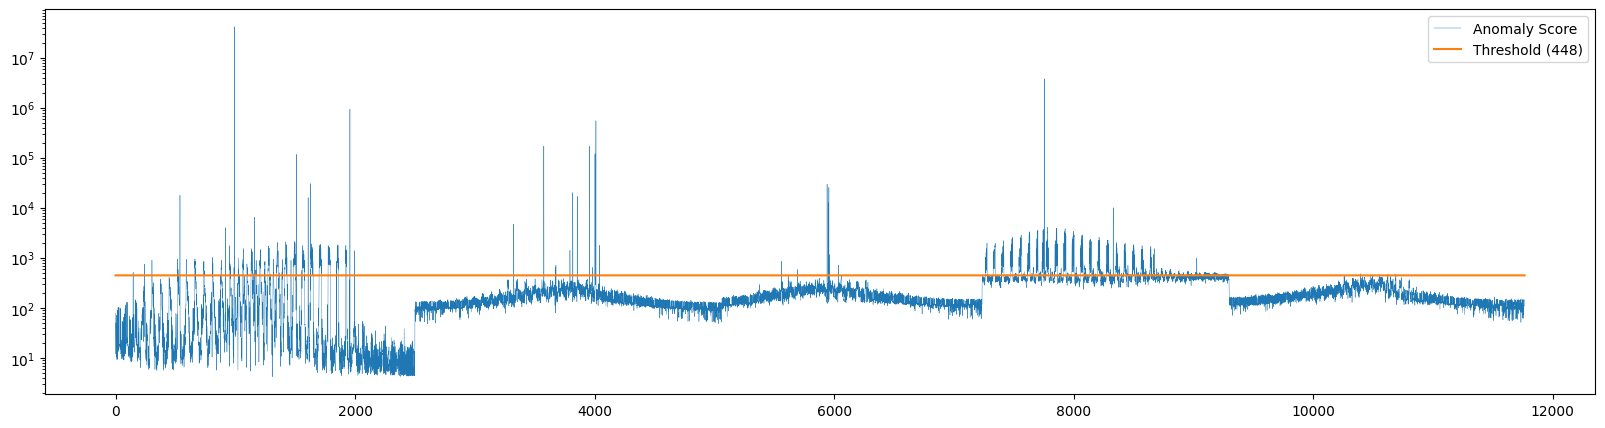

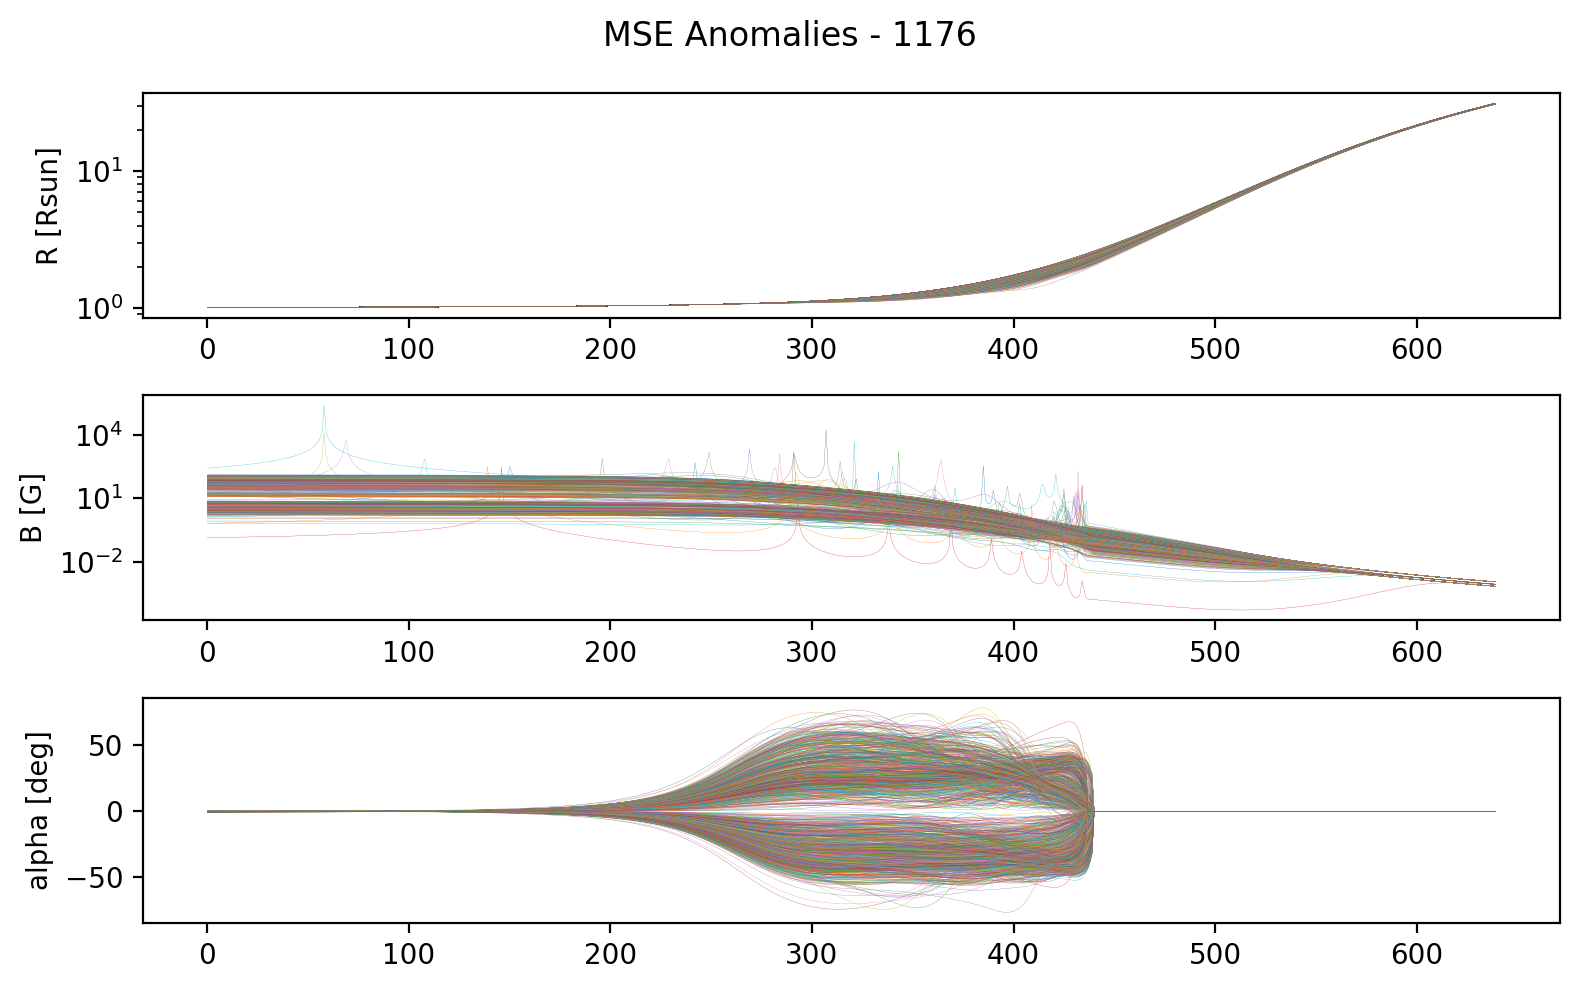

In [ ]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_scores, 0.1, opts.data_path, opts_eval.models_dir /  f"img/mse", 
                        scale="log", method="MSE", )

### MSE Reconstruction with Discriminator feedback

In [ ]:
reconstr_scores_discr = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device,
                                                      opts_eval.niter, madgan_reconstruction_discr_loss)

Anomaly Threshold:  57.606102
Found 1176 anomalies


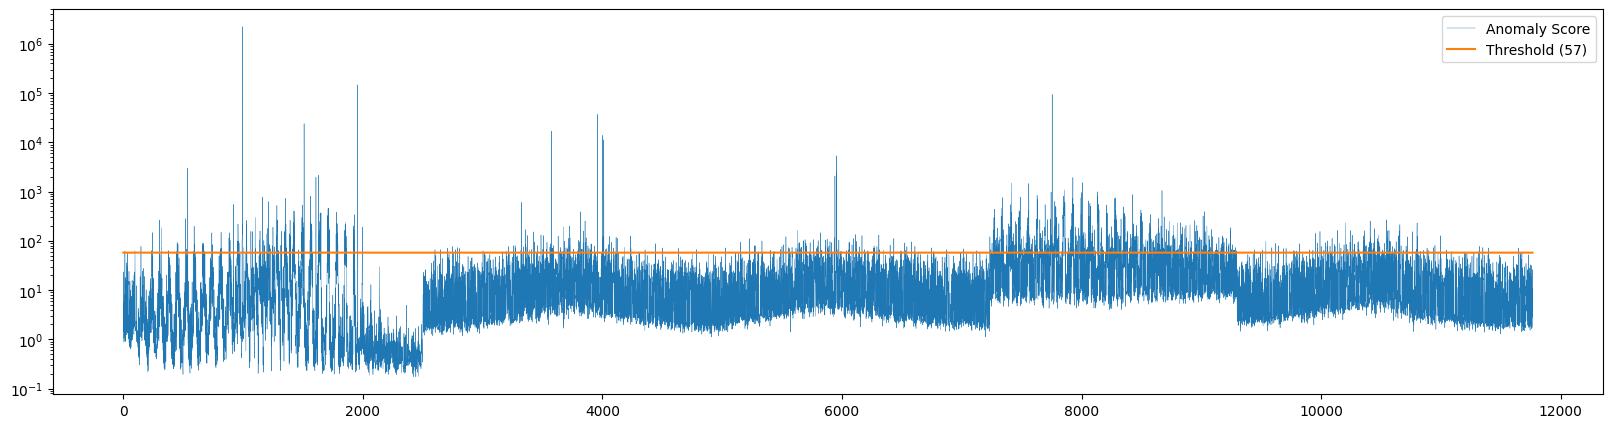

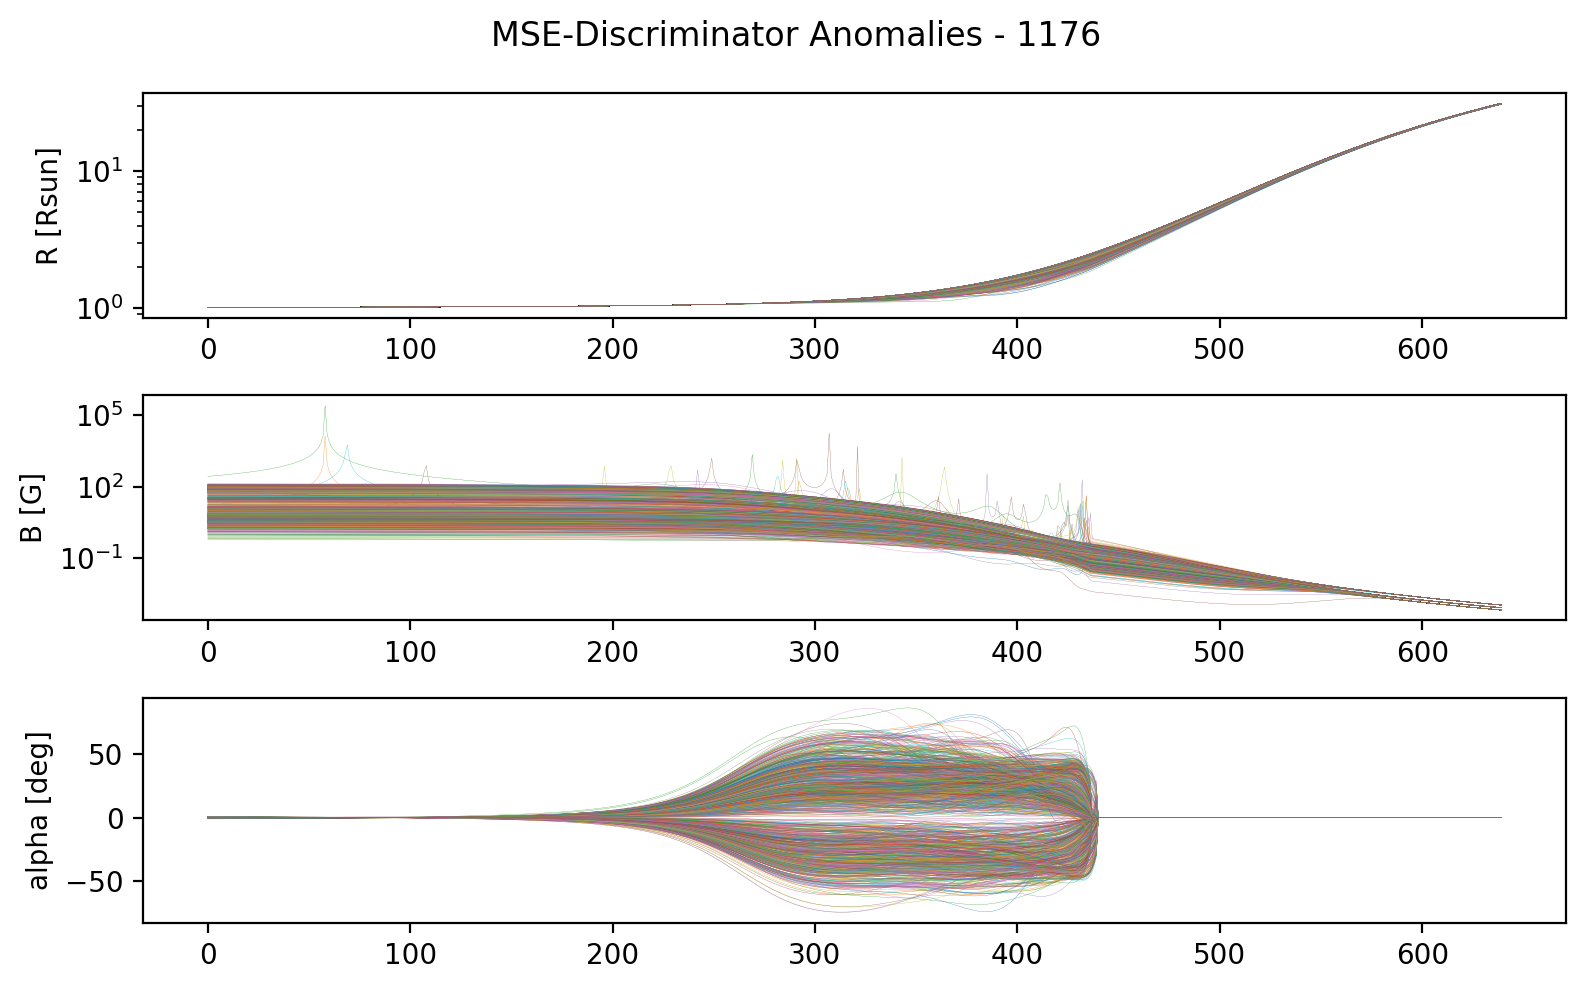

In [ ]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_scores_discr, 0.1, opts.data_path, opts_eval.models_dir /  f"img/mse_discr",
                        scale="log", method="MSE-Discriminator", logger=logger, logger_var="test/mse_discr")

### Feature Reconstruction

In [ ]:
reconstr_feature_scores = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device,
                                                        opts_eval.niter, madgan_reconstruction_discr_loss)

Anomaly Threshold:  56.845665
Found 1176 anomalies


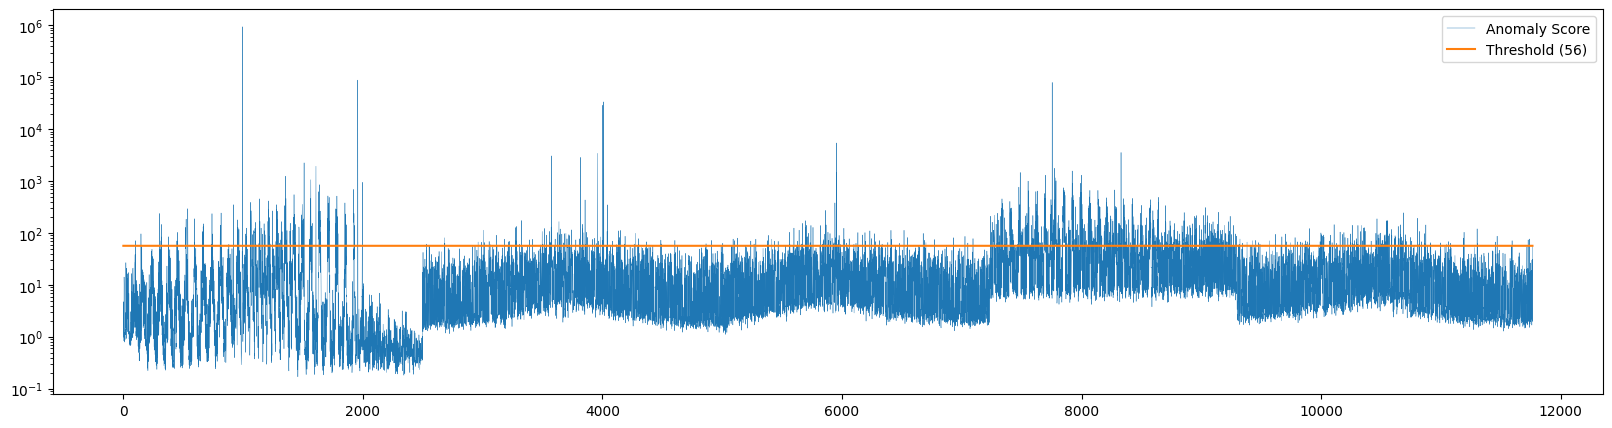

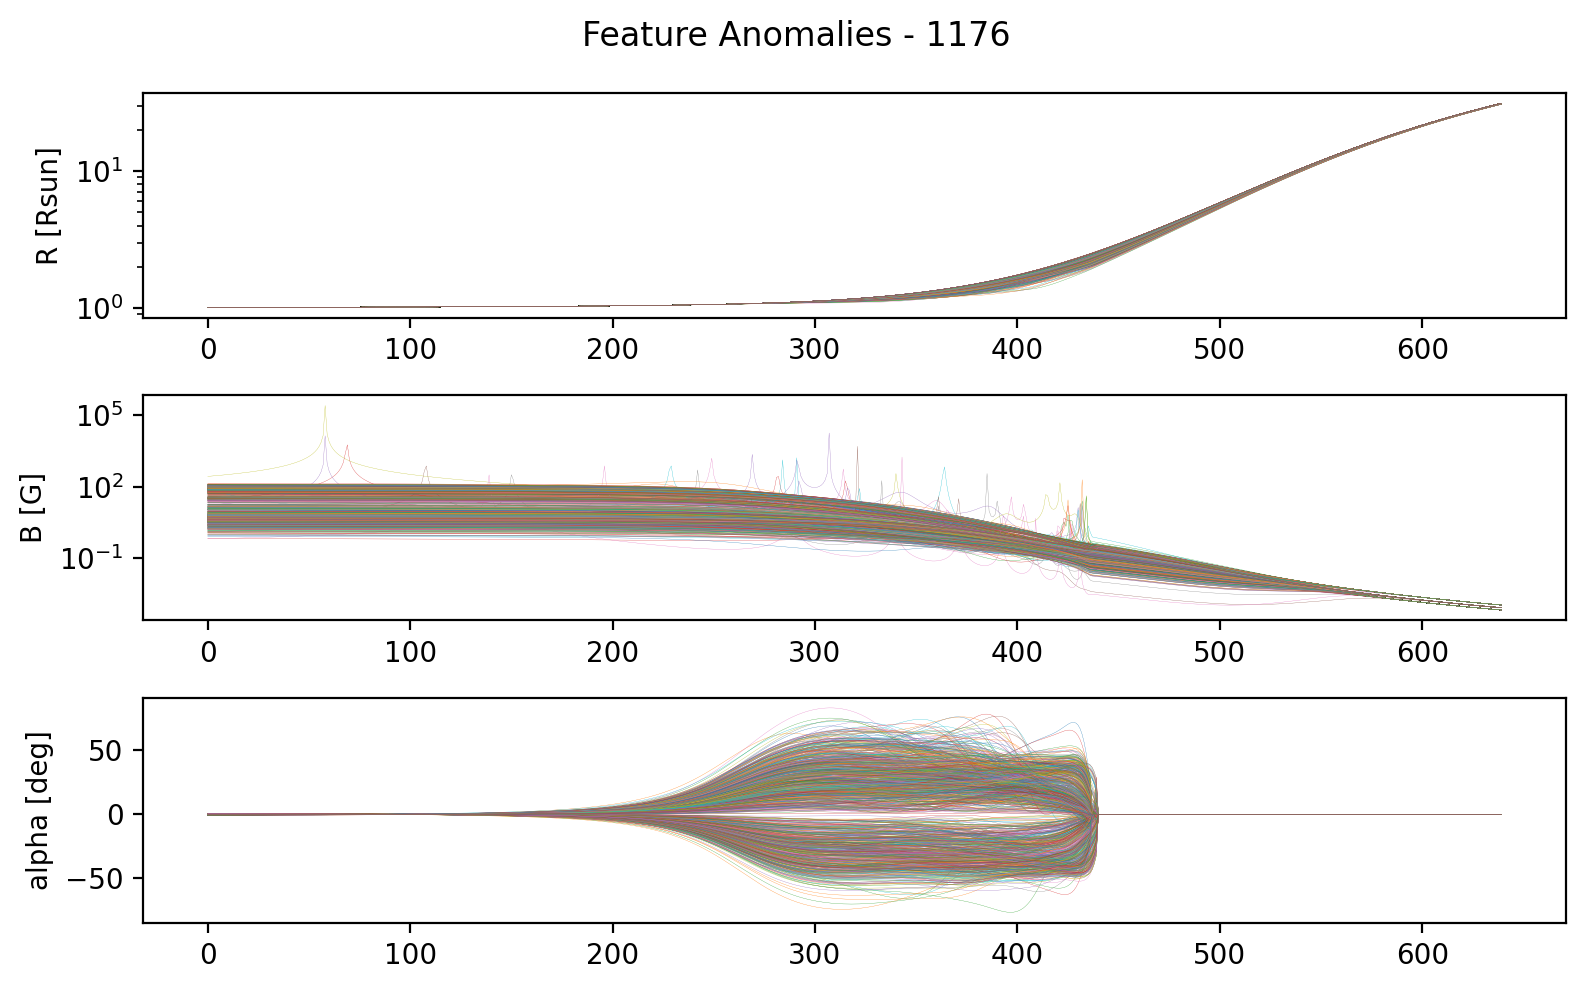

In [ ]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_feature_scores, 0.1, opts.data_path, opts_eval.models_dir /  f"img/mse_feature",
                        scale="log", method="Feature", logger=logger, logger_var="test/mse_feature")

In [ ]:
logger.flush()